In [1]:
# # 베이스 구글 드라이브 폴더 설정
# RUN_GDRIVE_PATH = "lecture_"

#### (옵션) 세션 끊김 방지

크롬 브라우저를 사용하실 경우,

1. 우클릭 - '검사' 클릭


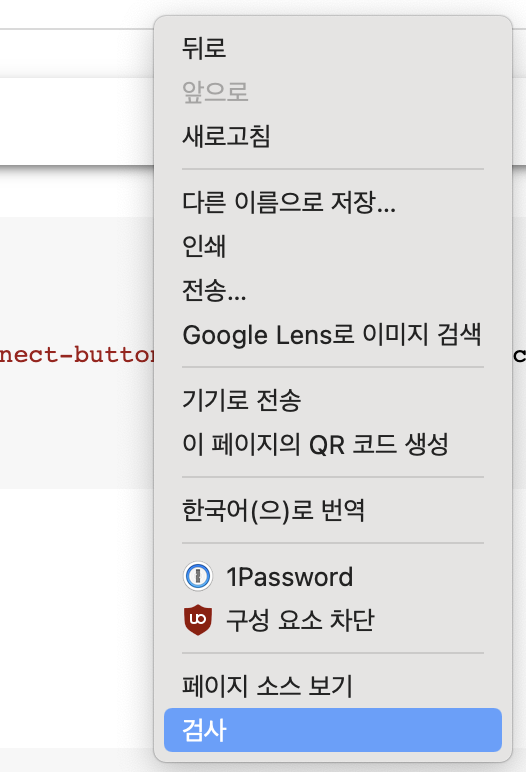

2. Console 메뉴 선택

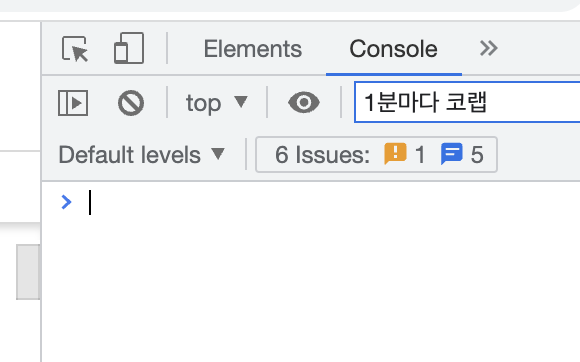

3. 다음의 코드 붙여넣고, 엔터.

```javascript
function ClickConnect(){
    console.log("1분마다 코랩 연결 끊김 방지"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
}
setInterval(ClickConnect, 1*60*1000)
```

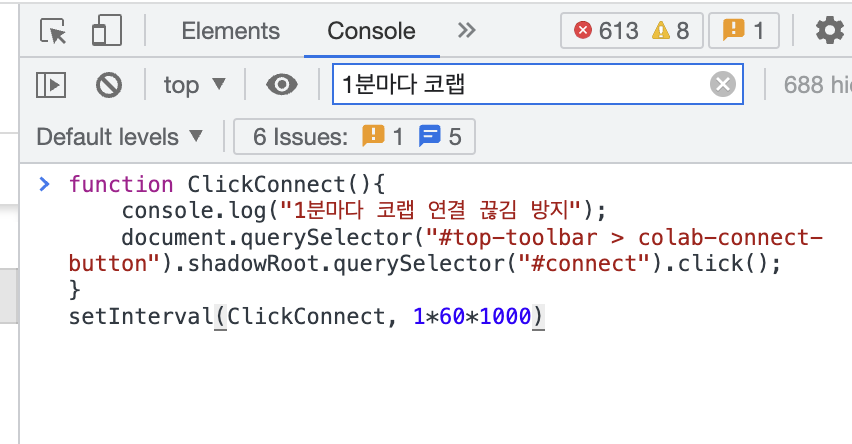

4. 1분마다 자동으로 '리소스' 창이 나타났다가 사라지며, 세션의 끊김을 방지합니다.

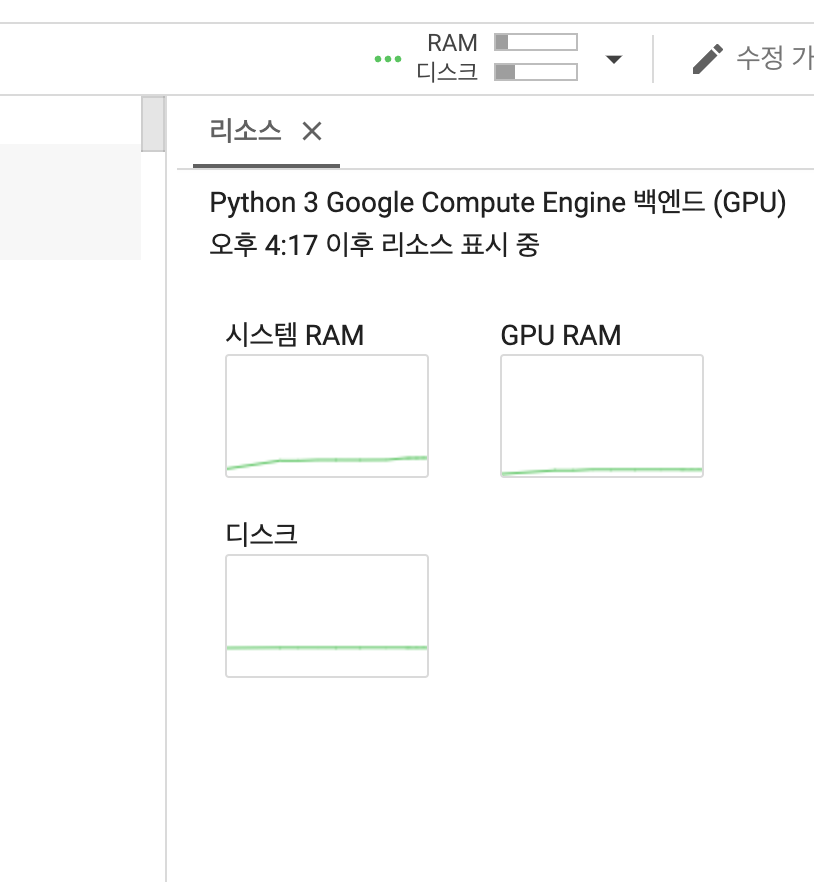

# 1.사전 준비

## 1.1.구글 드라이브 마운트

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

구글 드라이브의 자료를 저장할 폴더를 세팅합니다.

In [3]:
# import os

# base_gdrive_path = os.path.join('drive', 'MyDrive', RUN_GDRIVE_PATH)

설정한 폴더의 하위에 results 폴더를 생성합니다.

In [4]:
# from pathlib import Path
# import os

# result_path = os.path.join(base_gdrive_path, "results")
# Path(result_path).mkdir(parents=True, exist_ok=True)

## 1.2.Imports

In [41]:
# TensorFlow 및 tf.keras
import tensorflow as tf
from tensorflow import keras

# 도움 라이브러리
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

import os

2.8.2


## 1.3.유틸 설정

모델을 저장하는 함수입니다.

In [42]:
def save_model(model_name: str, model: keras.models.Model):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)

모델을 불러오는 함수입니다.

In [43]:
from keras.models import model_from_json
from typing import Optional

def load_model(
    model_name: str, with_weights_path: Optional[str] = None
) -> keras.models.Model:
    json_file = open(model_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    if with_weights_path:
        model.load_weights(with_weights_path)
    return model

# 2.CIFAR 100 데이터 세트

## 2.1.데이터 다운 및 분석

tfds를 활용하여 데이터를 가져옵니다.

https://www.tensorflow.org/datasets/catalog/cifar100

In [44]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

In [45]:
[train_ds, val_ds, test_ds], info = tfds.load('cifar100', split=['train[:90%]', 'train[90%:]', 'test'], with_info=True)

| 구분 | 개수 |
| --- | --- |
|'test'|10,000|
|'train'|50,000|


```
FeaturesDict({
    'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
})
```

In [46]:
info

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='~/tensorflow_datasets/cifar100/3.0.2',
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    dis

In [47]:
# !wget http://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
# !tar -xvf cifar-100-python.tar.gz

In [48]:
# def unpickle(file):
#     import pickle
#     with open(file, 'rb') as fo:
#         dict = pickle.load(fo)
#     return dict

In [49]:
# in_d = unpickle("cifar-100-python/meta")

In [50]:
# cifar_100_fine_labels = in_d['fine_label_names']

In [51]:
# cifar_100_fine_labels[91]

## 2.2.데이터 섞임 체크

트레이닝 데이터에서 100개만 뽑아 데이터가 잘 섞여있는지 체크합시다.

In [52]:
sample_ds = list(train_ds.take(100))

우리는 'label'을 예측할 것이므로, 이 'label'이 잘 섞여 있는지 살펴보면 됩니다.

In [53]:
list(map(lambda sample_ds_element: sample_ds_element['label'].numpy(), sample_ds))

[66,
 23,
 40,
 39,
 7,
 15,
 11,
 44,
 76,
 50,
 57,
 69,
 1,
 26,
 30,
 42,
 61,
 65,
 18,
 99,
 5,
 24,
 55,
 96,
 8,
 72,
 50,
 83,
 24,
 9,
 88,
 84,
 65,
 2,
 66,
 41,
 53,
 93,
 68,
 66,
 67,
 37,
 99,
 26,
 69,
 57,
 13,
 6,
 62,
 31,
 76,
 8,
 83,
 19,
 98,
 58,
 30,
 45,
 61,
 72,
 1,
 63,
 82,
 62,
 66,
 29,
 17,
 27,
 38,
 82,
 87,
 38,
 71,
 86,
 80,
 90,
 73,
 52,
 62,
 85,
 27,
 13,
 6,
 73,
 98,
 20,
 6,
 49,
 91,
 19,
 22,
 84,
 92,
 36,
 12,
 75,
 59,
 86,
 89,
 91]

숫자가 랜덤으로 된 것을 확인할 수 있습니다. 

`[0, 0, 0, 0, ..., 1, 1, 1, 1, ..., 2, 2, 2, 2, ...]`

이런 식으로 되어있지 않으므로, 잘 섞여있다고 할 수 있습니다.

## 2.3.이미지 크기 체크

이미지 크기는 `(32, 32, 3)` 으로 일정하므로 체크할 필요가 없습니다.

```
FeaturesDict({
    'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
})
```

## 2.4.전환

이 데이터 세트는 여러 가지로 구성되어 있습니다.

```
FeaturesDict({
    'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
})
```

우리는 이 블록에서, `'image'`와 `'label'`만 필요하므로, 이것만 골라냅시다.

다음과 같이 함수를 만들고,

In [54]:
transform_func = lambda dataset_element: (
        dataset_element['image'], 
        dataset_element['label'])

트레이닝, 검증, 테스트 데이터에 이를 적용합시다.

In [55]:
train_cifar_100_ds = train_ds.map(
    transform_func, num_parallel_calls=tf.data.AUTOTUNE)
val_cifar_100_ds = val_ds.map(
    transform_func, num_parallel_calls=tf.data.AUTOTUNE)
test_cifar_100_ds = test_ds.map(
    transform_func, num_parallel_calls=tf.data.AUTOTUNE)

## 2.5.데이터 살펴보기

### 2.5.1.살펴보기

샘플 데이터 하나를 살펴봅니다.

인덱스(`sample_index`)의 숫자를 변경해가며, 데이터 및 라벨을 살펴봅시다.

In [56]:
SAMPLE_NUM = 100

sample_index = 1   # `SAMPLE_NUM` 보다 작은 수로 설정합니다. 100일 경우, 0-99 사이의 값으로 설정.

In [57]:
sample_train_data = list(train_cifar_100_ds.take(SAMPLE_NUM))[sample_index]

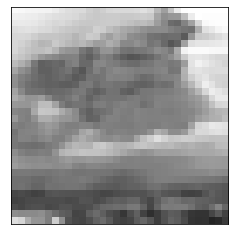

In [58]:
plt.figure()
plt.imshow(sample_train_data[0])
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

In [59]:
sample_train_data[1].numpy()

23

# 3.전처리

우리가 비교할 모든 모델은 다음의 입출력을 갖는다고 가정합니다.

- 입력
    - 모양 : (Batch, 32, 32, 3)
    - 값 분포 : 0~1 사이의 값
    - 데이터 타입 : tf.float32
- 출력
    - 모양 : (Batch, 1)
    - 값 분포 : 0-99 사이의 정수
    - 데이터 타입 : tf.float32

CIFAR-100 데이터 세트 -> 우리가 비교할 모델의 입출력 으로 전환합니다.

#### 1) 할당

In [60]:
train_our_classification_ds = train_cifar_100_ds
val_our_classification_ds = val_cifar_100_ds
test_our_classification_ds = test_cifar_100_ds

#### 2) 타입 확인 및 변경

In [61]:
train_our_classification_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

타입 변환을 위한 함수를 생성합니다.

In [62]:
def type_change(img, msk):
    img = tf.cast(img, tf.float32)
    msk = tf.cast(msk, tf.float32)
    return img, msk

생성한 함수를 적용합니다.

In [63]:
train_our_classification_ds = train_our_classification_ds.map(
    type_change, num_parallel_calls=tf.data.AUTOTUNE)
val_our_classification_ds = val_our_classification_ds.map(
    type_change, num_parallel_calls=tf.data.AUTOTUNE)
test_our_classification_ds = test_our_classification_ds.map(
    type_change, num_parallel_calls=tf.data.AUTOTUNE)

#### 3) 정규화 (Normalize)

정규화하는 함수를 함수 생성합니다.

In [64]:
def normalize_func(img, msk):
    img = img / 255.0
    msk = msk
    return img, msk

생성한 함수를 적용합니다.

In [65]:
train_our_classification_ds = train_our_classification_ds.map(
    normalize_func, num_parallel_calls=tf.data.AUTOTUNE)
val_our_classification_ds = val_our_classification_ds.map(
    normalize_func, num_parallel_calls=tf.data.AUTOTUNE)
test_our_classification_ds = test_our_classification_ds.map(
    normalize_func, num_parallel_calls=tf.data.AUTOTUNE)

#### 4) 결과

In [66]:
train_our_classification_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

이미지

In [67]:
list(train_our_classification_ds.take(1))[0][0]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[0.5921569 , 0.6039216 , 0.5686275 ],
        [0.5647059 , 0.5764706 , 0.5294118 ],
        [0.5529412 , 0.56078434, 0.5254902 ],
        ...,
        [0.17254902, 0.14901961, 0.15294118],
        [0.4392157 , 0.39215687, 0.3764706 ],
        [0.5686275 , 0.49803922, 0.47058824]],

       [[0.6       , 0.6117647 , 0.5882353 ],
        [0.5529412 , 0.5647059 , 0.5294118 ],
        [0.54509807, 0.5568628 , 0.53333336],
        ...,
        [0.26666668, 0.23137255, 0.23137255],
        [0.5137255 , 0.44313726, 0.41568628],
        [0.4745098 , 0.39607844, 0.36862746]],

       [[0.6392157 , 0.64705884, 0.6313726 ],
        [0.5882353 , 0.6       , 0.5686275 ],
        [0.5764706 , 0.58431375, 0.5647059 ],
        ...,
        [0.29411766, 0.25882354, 0.23529412],
        [0.39607844, 0.3372549 , 0.3019608 ],
        [0.3254902 , 0.3019608 , 0.28627452]],

       ...,

       [[0.5882353 , 0.5882353 , 0.63529414],
        [0.2   

라벨

In [68]:
list(train_our_classification_ds.take(1))[0][1]

<tf.Tensor: shape=(), dtype=float32, numpy=66.0>

- 입력
    - 모양 : (Batch, 32, 32, 3)
    - 값 분포 : 0~1 사이의 값
    - 데이터 타입 : tf.float32
- 출력
    - 모양 : (Batch, 1)
    - 값 분포 : 0-99 사이의 정수
    - 데이터 타입 : tf.float32

우리가 원하는 대로 잘 생성되었습니다.

# 4.공통 함수

이미지 플롯 함수

In [69]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

In [70]:
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(100))
  plt.yticks([])
  thisplot = plt.bar(range(100), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

# 5.모델

기본 변수 설정

In [71]:
INPUT_SHAPE = (32, 32, 3)
CLASS_NUM = 100

## 5.1.모델1

#### 1) 모델 이름 설정

In [72]:
MODEL_NAME = 'model_1'

#### 2) 모델 구성

In [73]:
def my_model_1(input_shape=INPUT_SHAPE, class_num=CLASS_NUM):
    input_1 = keras.layers.Input(input_shape)
    flatten_1 = keras.layers.Flatten()(input_1)
    dense_1 = keras.layers.Dense(1536, activation="relu")(flatten_1)
    dense_2 = keras.layers.Dense(384, activation="relu")(dense_1)
    dense_3 = keras.layers.Dense(CLASS_NUM, activation="softmax")(dense_2)

    return keras.models.Model(inputs=[input_1], outputs=[dense_3])

In [74]:
model_1 = my_model_1()

#### 3) 모델 Summary 및 Plot

Summary

In [75]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 1536)              4720128   
                                                                 
 dense_4 (Dense)             (None, 384)               590208    
                                                                 
 dense_5 (Dense)             (None, 100)               38500     
                                                                 
Total params: 5,348,836
Trainable params: 5,348,836
Non-trainable params: 0
_________________________________________________________________


Plot

구글 드라이브의 'results' 폴더에 모델 구조가 저장됩니다.

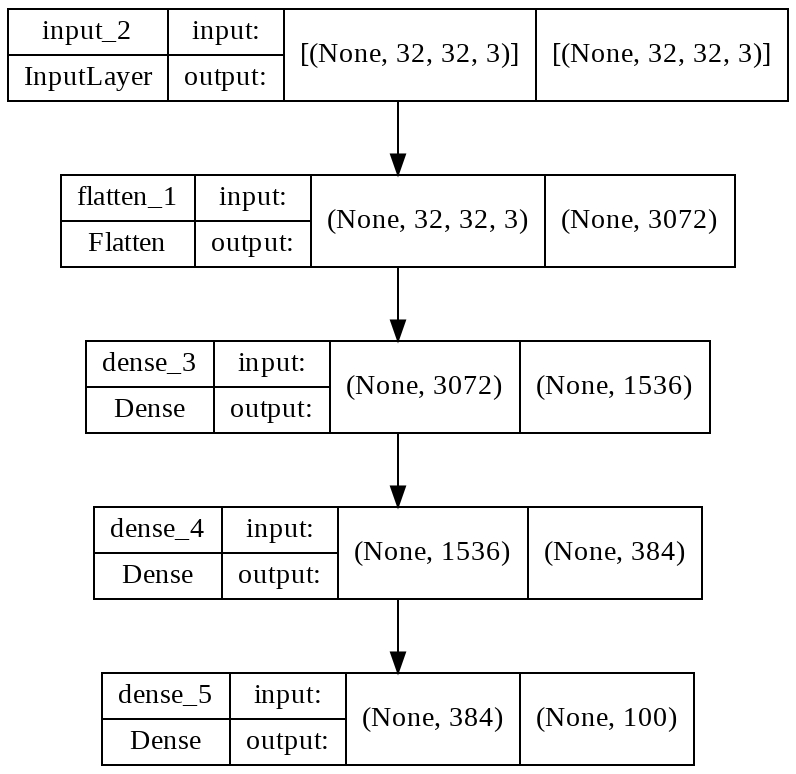

In [76]:
from tensorflow.keras.utils import plot_model

# filename = os.path.join(result_path, f'{MODEL_NAME}.png')
filename = os.path.join(f'{MODEL_NAME}.png')
plot_model(model_1, show_shapes=True, to_file=filename, expand_nested=True, dpi=144)

#### 4) 모델 트레이닝

컴파일

In [77]:
model_1.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

트레이닝

In [78]:
BATCH_SIZE = 32
EPOCH = 50

In [79]:
train_our_classification_ds_1 = train_our_classification_ds.shuffle(1000).batch(BATCH_SIZE)
val_our_classification_ds_1 = val_our_classification_ds.batch(BATCH_SIZE)
test_our_classification_ds_1 = test_our_classification_ds.batch(BATCH_SIZE)

In [80]:
train_our_classification_ds_1

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [81]:
# checkpoint_filename = os.path.join(result_path, f'checkpoint_{MODEL_NAME}.h5')
checkpoint_filename = os.path.join(f'checkpoint_{MODEL_NAME}.h5')

In [82]:
from tensorflow.keras.callbacks import ModelCheckpoint

history_1 = model_1.fit(
    train_our_classification_ds_1,
    epochs=EPOCH,
    callbacks=[ModelCheckpoint(filepath=checkpoint_filename, verbose=0, save_best_only=True, save_weights_only=True)],
    validation_data=val_our_classification_ds_1)

Epoch 1/50
1407/1407 [==============================] - 14s 8ms/step - loss: 4.3358 - accuracy: 0.0396 - val_loss: 3.9953 - val_accuracy: 0.0792
Epoch 2/50
1407/1407 [==============================] - 7s 5ms/step - loss: 3.8776 - accuracy: 0.0983 - val_loss: 3.8121 - val_accuracy: 0.1188
Epoch 3/50
1407/1407 [==============================] - 7s 5ms/step - loss: 3.7131 - accuracy: 0.1293 - val_loss: 3.6688 - val_accuracy: 0.1362
Epoch 4/50
1407/1407 [==============================] - 7s 5ms/step - loss: 3.5949 - accuracy: 0.1482 - val_loss: 3.6012 - val_accuracy: 0.1528
Epoch 5/50
1407/1407 [==============================] - 7s 5ms/step - loss: 3.5117 - accuracy: 0.1639 - val_loss: 3.5914 - val_accuracy: 0.1578
Epoch 6/50
1407/1407 [==============================] - 7s 5ms/step - loss: 3.4544 - accuracy: 0.1732 - val_loss: 3.4871 - val_accuracy: 0.1762
Epoch 7/50
1407/1407 [==============================] - 7s 5ms/step - loss: 3.4060 - accuracy: 0.1818 - val_loss: 3.4938 - val_accuracy

#### 5) 트레이닝 진행 결과

정확도

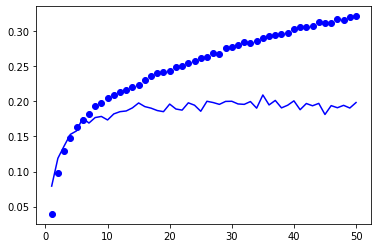

In [83]:
history_accuracy = history_1.history["accuracy"]
history_val_accuracy = history_1.history["val_accuracy"]

epochs = range(1, len(history_accuracy) + 1)
plt.plot(epochs, history_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_val_accuracy, "b", label="Validation accuracy")


로스

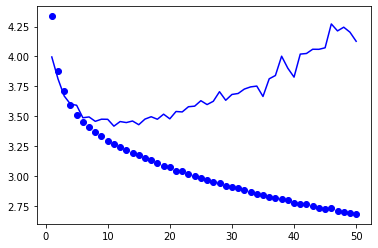

In [84]:
history_loss = history_1.history["loss"]
history_val_loss = history_1.history["val_loss"]

epochs = range(1, len(history_loss) + 1)
plt.plot(epochs, history_loss, "bo", label="Training loss")
plt.plot(epochs, history_val_loss, "b", label="Validation loss")


#### 6) 테스트

In [85]:
test_loss, test_acc = model_1.evaluate(test_our_classification_ds_1)
print('테스트 정확도:', test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 4.1480 - accuracy: 0.1933
테스트 정확도: 0.19329999387264252


#### 7) 예측 샘플

In [86]:
num_rows = 5
num_cols = 3

In [87]:
predictions = model_1.predict(test_our_classification_ds_1)

In [88]:
test_data = list(test_our_classification_ds.take(num_rows*num_cols))
test_images = list(map(lambda el: tf.cast(el[0]*255, tf.uint8).numpy(), test_data))
test_labels = list(map(lambda el: tf.cast(el[1], tf.uint8).numpy(), test_data))

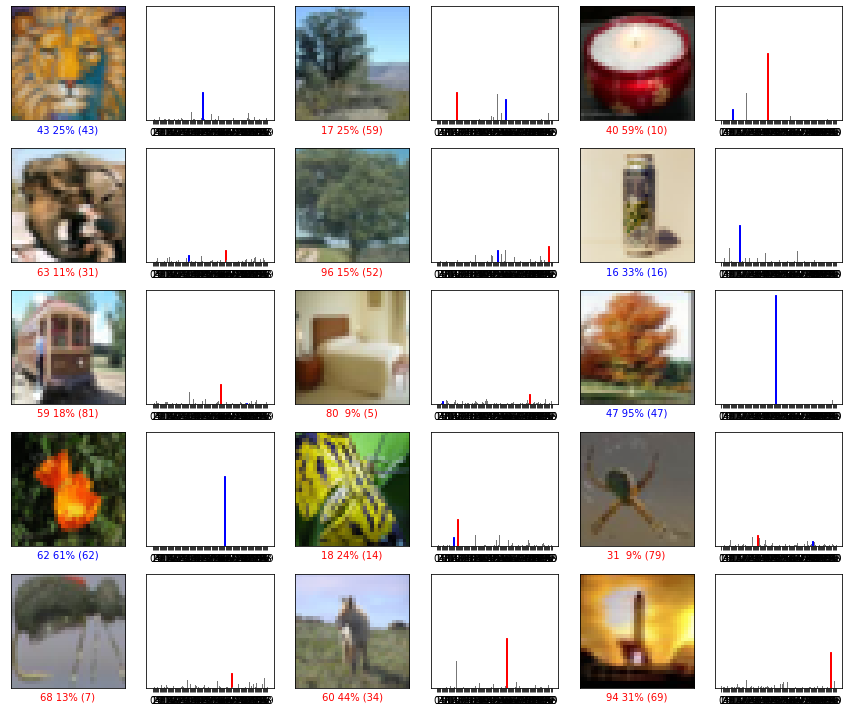

In [89]:
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## 5.2.모델2

#### 1) 모델 이름 설정

In [90]:
MODEL_NAME = 'model_2'

#### 2) 모델 구성

In [91]:
def my_model_2(input_shape=INPUT_SHAPE, class_num=CLASS_NUM):
    input_1 = keras.layers.Input(input_shape)
    flatten_1 = keras.layers.Flatten()(input_1)
    dense_3 = keras.layers.Dense(CLASS_NUM, activation="softmax")(flatten_1)

    return keras.models.Model(inputs=[input_1], outputs=[dense_3])

In [92]:
model_2 = my_model_2()

#### 3) 모델 Summary 및 Plot

Summary

In [93]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               307300    
                                                                 
Total params: 307,300
Trainable params: 307,300
Non-trainable params: 0
_________________________________________________________________


Plot

구글 드라이브의 'results' 폴더에 모델 구조가 저장됩니다.

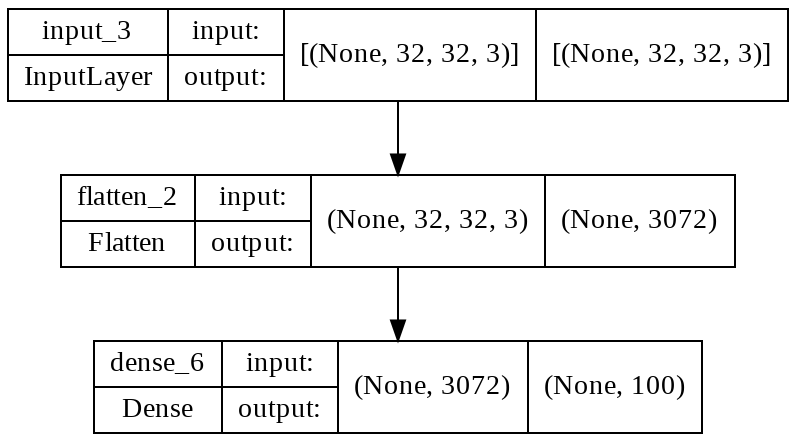

In [94]:
from tensorflow.keras.utils import plot_model

# filename = os.path.join(result_path, f'{MODEL_NAME}.png')
filename = os.path.join(f'{MODEL_NAME}.png')
plot_model(model_2, show_shapes=True, to_file=filename, expand_nested=True, dpi=144)

#### 4) 모델 트레이닝

컴파일

In [95]:
model_2.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

트레이닝

In [96]:
BATCH_SIZE = 32
EPOCH = 50

In [97]:
train_our_classification_ds_1 = train_our_classification_ds.shuffle(1000).batch(BATCH_SIZE)
val_our_classification_ds_1 = val_our_classification_ds.batch(BATCH_SIZE)
test_our_classification_ds_1 = test_our_classification_ds.batch(BATCH_SIZE)

In [98]:
train_our_classification_ds_1

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [99]:
# checkpoint_filename = os.path.join(result_path, f'checkpoint_{MODEL_NAME}.h5')
checkpoint_filename = os.path.join(f'checkpoint_{MODEL_NAME}.h5')

In [100]:
from tensorflow.keras.callbacks import ModelCheckpoint

history_2 = model_2.fit(
    train_our_classification_ds_1,
    epochs=EPOCH,
    callbacks=[ModelCheckpoint(filepath=checkpoint_filename, verbose=0, save_best_only=True, save_weights_only=True)],
    validation_data=val_our_classification_ds_1)

Epoch 1/50
1407/1407 [==============================] - 7s 5ms/step - loss: 4.4759 - accuracy: 0.0870 - val_loss: 4.4954 - val_accuracy: 0.0994
Epoch 2/50
1407/1407 [==============================] - 6s 4ms/step - loss: 4.2157 - accuracy: 0.1246 - val_loss: 4.4472 - val_accuracy: 0.1066
Epoch 3/50
1407/1407 [==============================] - 6s 4ms/step - loss: 4.1250 - accuracy: 0.1363 - val_loss: 4.4341 - val_accuracy: 0.1070
Epoch 4/50
1407/1407 [==============================] - 7s 5ms/step - loss: 4.0703 - accuracy: 0.1464 - val_loss: 4.3222 - val_accuracy: 0.1214
Epoch 5/50
1407/1407 [==============================] - 6s 5ms/step - loss: 4.0209 - accuracy: 0.1544 - val_loss: 4.4291 - val_accuracy: 0.1270
Epoch 6/50
1407/1407 [==============================] - 6s 4ms/step - loss: 3.9628 - accuracy: 0.1619 - val_loss: 4.3547 - val_accuracy: 0.1332
Epoch 7/50
1407/1407 [==============================] - 7s 5ms/step - loss: 3.9306 - accuracy: 0.1656 - val_loss: 4.3859 - val_accuracy:

#### 5) 트레이닝 진행 결과

정확도

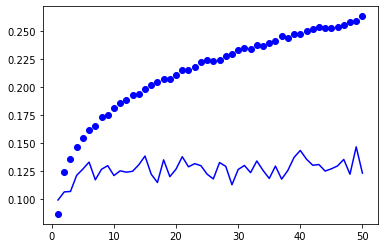

In [101]:
history_accuracy = history_2.history["accuracy"]
history_val_accuracy = history_2.history["val_accuracy"]

epochs = range(1, len(history_accuracy) + 1)
plt.plot(epochs, history_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_val_accuracy, "b", label="Validation accuracy")


로스

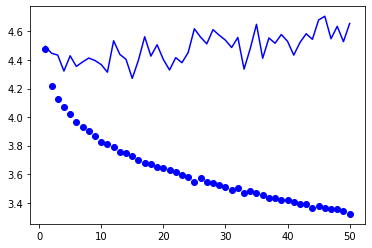

In [102]:
history_loss = history_2.history["loss"]
history_val_loss = history_2.history["val_loss"]

epochs = range(1, len(history_loss) + 1)
plt.plot(epochs, history_loss, "bo", label="Training loss")
plt.plot(epochs, history_val_loss, "b", label="Validation loss")


#### 6) 테스트

In [103]:
test_loss, test_acc = model_2.evaluate(test_our_classification_ds_1)
print('테스트 정확도:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 4.6812 - accuracy: 0.1228
테스트 정확도: 0.12280000001192093


#### 7) 예측 샘플

In [104]:
num_rows = 5
num_cols = 3

In [105]:
predictions = model_2.predict(test_our_classification_ds_1)

In [106]:
test_data = list(test_our_classification_ds.take(num_rows*num_cols))
test_images = list(map(lambda el: tf.cast(el[0]*255, tf.uint8).numpy(), test_data))
test_labels = list(map(lambda el: tf.cast(el[1], tf.uint8).numpy(), test_data))

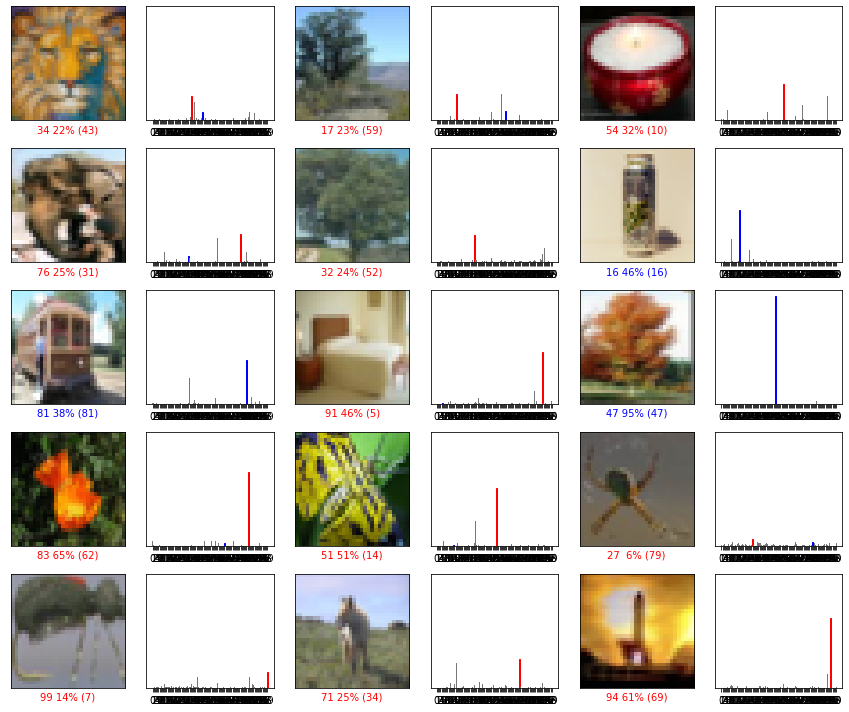

In [107]:
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## 5.3.모델3

#### 1) 모델 이름 설정

In [108]:
MODEL_NAME = 'model_3'

#### 2) 모델 구성

In [109]:
def my_model_3(input_shape=INPUT_SHAPE, class_num=CLASS_NUM):
    input_1 = keras.layers.Input(input_shape)
    flatten_1 = keras.layers.Flatten()(input_1)
    dense_3 = keras.layers.Dense(CLASS_NUM, activation="softmax")(flatten_1)

    return keras.models.Model(inputs=[input_1], outputs=[dense_3])

In [110]:
model_3 = my_model_3()

#### 3) 모델 Summary 및 Plot

Summary

In [111]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_7 (Dense)             (None, 100)               307300    
                                                                 
Total params: 307,300
Trainable params: 307,300
Non-trainable params: 0
_________________________________________________________________


Plot

구글 드라이브의 'results' 폴더에 모델 구조가 저장됩니다.

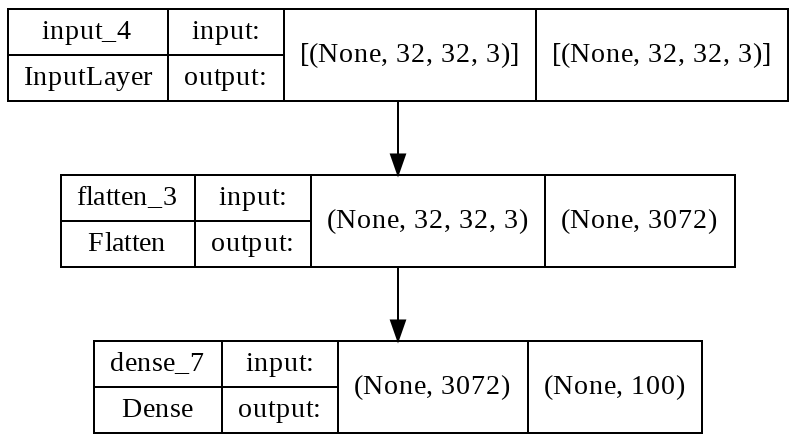

In [112]:
from tensorflow.keras.utils import plot_model

# filename = os.path.join(result_path, f'{MODEL_NAME}.png')
filename = os.path.join(f'{MODEL_NAME}.png')
plot_model(model_3, show_shapes=True, to_file=filename, expand_nested=True, dpi=144)

#### 4) 모델 트레이닝

컴파일

In [113]:
model_3.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

트레이닝

In [114]:
BATCH_SIZE = 32
EPOCH = 50

In [115]:
train_our_classification_ds_1 = train_our_classification_ds.shuffle(1000).batch(BATCH_SIZE)
val_our_classification_ds_1 = val_our_classification_ds.batch(BATCH_SIZE)
test_our_classification_ds_1 = test_our_classification_ds.batch(BATCH_SIZE)

In [116]:
train_our_classification_ds_1

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [117]:
# checkpoint_filename = os.path.join(result_path, f'checkpoint_{MODEL_NAME}.h5')
checkpoint_filename = os.path.join(f'checkpoint_{MODEL_NAME}.h5')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

history_3 = model_3.fit(
    train_our_classification_ds_1,
    epochs=EPOCH,
    callbacks=[ModelCheckpoint(filepath=checkpoint_filename, verbose=0, save_best_only=True, save_weights_only=True)],
    validation_data=val_our_classification_ds_1)

Epoch 1/50
1407/1407 [==============================] - 7s 5ms/step - loss: 4.4869 - accuracy: 0.0890 - val_loss: 4.3762 - val_accuracy: 0.1116
Epoch 2/50
1407/1407 [==============================] - 6s 5ms/step - loss: 4.2215 - accuracy: 0.1236 - val_loss: 4.2529 - val_accuracy: 0.1220
Epoch 3/50
1407/1407 [==============================] - 6s 4ms/step - loss: 4.1216 - accuracy: 0.1352 - val_loss: 4.3702 - val_accuracy: 0.1274
Epoch 4/50
1407/1407 [==============================] - 7s 5ms/step - loss: 4.0607 - accuracy: 0.1479 - val_loss: 4.2516 - val_accuracy: 0.1242
Epoch 5/50
1232/1407 [=========================>....] - ETA: 0s - loss: 4.0170 - accuracy: 0.1534

#### 5) 트레이닝 진행 결과

정확도

In [ ]:
history_accuracy = history_3.history["accuracy"]
history_val_accuracy = history_3.history["val_accuracy"]

epochs = range(1, len(history_accuracy) + 1)
plt.plot(epochs, history_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_val_accuracy, "b", label="Validation accuracy")


로스

In [ ]:
history_loss = history_3.history["loss"]
history_val_loss = history_3.history["val_loss"]

epochs = range(1, len(history_loss) + 1)
plt.plot(epochs, history_loss, "bo", label="Training loss")
plt.plot(epochs, history_val_loss, "b", label="Validation loss")


#### 6) 테스트

In [ ]:
test_loss, test_acc = model_3.evaluate(test_our_classification_ds_1)
print('테스트 정확도:', test_acc)

#### 7) 예측 샘플

In [ ]:
num_rows = 5
num_cols = 3

In [ ]:
predictions = model_3.predict(test_our_classification_ds_1)

In [ ]:
test_data = list(test_our_classification_ds.take(num_rows*num_cols))
test_images = list(map(lambda el: tf.cast(el[0]*255, tf.uint8).numpy(), test_data))
test_labels = list(map(lambda el: tf.cast(el[1], tf.uint8).numpy(), test_data))

In [ ]:
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## 5.4.모델4

#### 1) 모델 이름 설정

In [ ]:
MODEL_NAME = 'model_4'

#### 2) 모델 구성

In [ ]:
def my_model_4(input_shape=INPUT_SHAPE, class_num=CLASS_NUM):
    input_1 = keras.layers.Input(input_shape)
    flatten_1 = keras.layers.Flatten()(input_1)
    dense_3 = keras.layers.Dense(CLASS_NUM, activation="softmax")(flatten_1)

    return keras.models.Model(inputs=[input_1], outputs=[dense_3])

In [ ]:
model_4 = my_model_4()

#### 3) 모델 Summary 및 Plot

Summary

In [ ]:
model_4.summary()

Plot

구글 드라이브의 'results' 폴더에 모델 구조가 저장됩니다.

In [ ]:
from tensorflow.keras.utils import plot_model

# filename = os.path.join(result_path, f'{MODEL_NAME}.png')
filename = os.path.join(f'{MODEL_NAME}.png')
plot_model(model_4, show_shapes=True, to_file=filename, expand_nested=True, dpi=144)

#### 4) 모델 트레이닝

컴파일

In [ ]:
model_4.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

트레이닝

In [ ]:
BATCH_SIZE = 32
EPOCH = 50

In [ ]:
train_our_classification_ds_1 = train_our_classification_ds.shuffle(1000).batch(BATCH_SIZE)
val_our_classification_ds_1 = val_our_classification_ds.batch(BATCH_SIZE)
test_our_classification_ds_1 = test_our_classification_ds.batch(BATCH_SIZE)

In [ ]:
train_our_classification_ds_1

In [ ]:
# checkpoint_filename = os.path.join(result_path, f'checkpoint_{MODEL_NAME}.h5')
checkpoint_filename = os.path.join(f'checkpoint_{MODEL_NAME}.h5')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

history_4 = model_4.fit(
    train_our_classification_ds_1,
    epochs=EPOCH,
    callbacks=[ModelCheckpoint(filepath=checkpoint_filename, verbose=0, save_best_only=True, save_weights_only=True)],
    validation_data=val_our_classification_ds_1)

#### 5) 트레이닝 진행 결과

정확도

In [ ]:
history_accuracy = history_4.history["accuracy"]
history_val_accuracy = history_4.history["val_accuracy"]

epochs = range(1, len(history_accuracy) + 1)
plt.plot(epochs, history_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_val_accuracy, "b", label="Validation accuracy")


로스

In [ ]:
history_loss = history_4.history["loss"]
history_val_loss = history_4.history["val_loss"]

epochs = range(1, len(history_loss) + 1)
plt.plot(epochs, history_loss, "bo", label="Training loss")
plt.plot(epochs, history_val_loss, "b", label="Validation loss")


#### 6) 테스트

In [ ]:
test_loss, test_acc = model_4.evaluate(test_our_classification_ds_1)
print('테스트 정확도:', test_acc)

#### 7) 예측 샘플

In [ ]:
num_rows = 5
num_cols = 3

In [ ]:
predictions = model_4.predict(test_our_classification_ds_1)

In [ ]:
test_data = list(test_our_classification_ds.take(num_rows*num_cols))
test_images = list(map(lambda el: tf.cast(el[0]*255, tf.uint8).numpy(), test_data))
test_labels = list(map(lambda el: tf.cast(el[1], tf.uint8).numpy(), test_data))

In [ ]:
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()